# Features and images ensembling and fit generator

In this notebook are going see how to ensemble features with images in a classification problem.

The main idea is to show how to :
* ensemble CNN with other architectures to train a network using images and features together.
* implement a fit generator with a network with multiple inputs.

The dataset consists on features a and images of leaves from 100 different plants and the task consist of the Leaf Classification contest of [Kaggle](https://www.kaggle.com/c/leaf-classification):
> The objective of this playground competition is to use binary leaf images and extracted features, including shape, margin & texture, to accurately identify 99 species of plants. Leaves, due to their volume, prevalence, and unique characteristics, are an effective means of differentiating plant species. They also provide a fun introduction to applying techniques that involve image-based features.

The dataset loading code was taken from https://www.kaggle.com/abhmul/keras-convnet-lb-0-0052-w-visualization as well as some code.

So, to brief the idea is to generate a leaf classifier as a excuse to make an hybrid DNN.

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

here we load the dataset

In [4]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

# A large amount of the data loading code is based on najeebkhan's kernel
# Check it out at https://www.kaggle.com/najeebkhan/leaf-classification/neural-network-through-keras
root = './all'
np.random.seed(2016)
split_random_state = 7
split = .8
image_max_size = 512


def load_numeric_training(standardize=False):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'train.csv'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(scaler, standardize=False):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'test.csv'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=image_max_size):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=image_max_size, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')

Loading the training data...
Training data loaded!


some inspection

number of categories

In [7]:
n_cats = len(np.unique(y_tr))
print(n_cats)

99


In [8]:
X_num_tr.shape

(792, 192)

In [16]:
X_img_tr.shape

(792, 512, 512, 1)

Note that the dataset consist of 792 samples of a vector of 192 features and a image.

Here we resized the images from the original size, to 512x512 pixels.

## DNN using only features

Here we build a deep feed forward NN using only the features.

We implement some callbacks such as Early Stopping and Reduce LR on plateau to avoid overfitting and to increase the accuracy of the model.

In [13]:
import keras
from keras import Sequential
from keras import Model
from keras.layers import ReLU, Dense, Conv2D, Softmax, Conv1D, Flatten, Dropout, Input,GlobalMaxPooling2D,MaxPooling2D, Convolution2D, Concatenate, merge
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [22]:
def features_model():
    model = Sequential()
    model.add(Dense(64, input_shape = (192,), activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dense(n_cats,activation = 'softmax', name = 'out_layer'))
    return model

In [24]:
# model 
# model = Sequential()
# model.add(Dense(150, input_shape = (192,), activation = 'relu'))
# model.add(Dropout(0.4))
# model.add(Dense(120, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(110, activation = 'relu'))
# model.add(Dense(105, activation = 'relu'))
# model.add(Dense(100, activation = 'relu'))
# model.add(Dense(n_cats,activation = 'softmax', name = 'out_layer'))

model = features_model()

from keras.callbacks import ReduceLROnPlateau
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                        patience=5, verbose=1, mode='auto', 
                        min_delta=0.01,  min_lr=0)
erl = EarlyStopping(monitor='val_loss',
                        patience=10, verbose=1, mode='auto', 
                        min_delta=0.01)

callbacks = [rlr,erl]

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                12352     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
_________________________________________________________________
out_layer (Dense)            (None, 99)                12771     
Total params: 33,443
Trainable params: 33,443
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_num_tr, y_tr_cat, batch_size = 10, epochs = 100, validation_data=(X_num_val, y_val_cat), callbacks=[rlr, erl])

Train on 792 samples, validate on 99 samples
Epoch 1/100
792/792 [==============================] - 1s 836us/step - loss: 4.5903 - acc: 0.0114 - val_loss: 4.5628 - val_acc: 0.1111
Epoch 2/100
792/792 [==============================] - 0s 302us/step - loss: 4.5105 - acc: 0.0707 - val_loss: 4.3837 - val_acc: 0.1616
Epoch 3/100
792/792 [==============================] - 0s 303us/step - loss: 4.1789 - acc: 0.1086 - val_loss: 3.7947 - val_acc: 0.2727
Epoch 4/100
792/792 [==============================] - 0s 301us/step - loss: 3.5232 - acc: 0.1717 - val_loss: 3.0790 - val_acc: 0.3333
Epoch 5/100
792/792 [==============================] - 0s 303us/step - loss: 2.9595 - acc: 0.2462 - val_loss: 2.5956 - val_acc: 0.4343
Epoch 6/100
792/792 [==============================] - 0s 297us/step - loss: 2.5563 - acc: 0.3182 - val_loss: 2.2431 - val_acc: 0.5758
Epoch 7/100
792/792 [==============================] - 0s 296us/step - loss: 2.2460 - acc: 0.3965 - val_loss: 1.9904 - val_acc: 0.6061
Epoch 8/10

792/792 [==============================] - 0s 296us/step - loss: 0.2687 - acc: 0.9205 - val_loss: 0.3693 - val_acc: 0.9192
Epoch 61/100
792/792 [==============================] - 0s 297us/step - loss: 0.3148 - acc: 0.9091 - val_loss: 0.3410 - val_acc: 0.9192
Epoch 62/100
792/792 [==============================] - 0s 300us/step - loss: 0.2589 - acc: 0.9280 - val_loss: 0.3432 - val_acc: 0.9394
Epoch 63/100
792/792 [==============================] - 0s 302us/step - loss: 0.2792 - acc: 0.9154 - val_loss: 0.3528 - val_acc: 0.9192

Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 64/100
792/792 [==============================] - 0s 299us/step - loss: 0.2793 - acc: 0.9217 - val_loss: 0.3452 - val_acc: 0.9091
Epoch 65/100
792/792 [==============================] - 0s 298us/step - loss: 0.2616 - acc: 0.9331 - val_loss: 0.3430 - val_acc: 0.9091
Epoch 66/100
792/792 [==============================] - 0s 297us/step - loss: 0.2266 - acc: 0.9432 - val_loss: 0.346

### Fit generator first implementation

Here we implement a generator of keras following [a very *detailed example of how to use data generators with Keras
*](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) and a nice discussion.

In [19]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, features, targets, 
                 n_classes =99, batch_size=32,  shuffle=True):
        'Initialization'
        self.n_classes = n_classes
        self.n_vals = len(targets)
        self.list_IDs = np.arange(self.n_vals)
        self.batch_size = batch_size
        self.features = features
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.features[list_IDs_temp]
        y = self.targets_mc[list_IDs_temp]

#        # Generate data
#        for i, ID in enumerate(list_IDs_temp):
#            # Store sample
#            X[i,] = np.load('data/' + ID + '.npy')
#
#            # Store class
#            y[i] = self.labels[ID]

        return X, y

here we implement the generator for both, the training and the validation set. Note that at this point the generator only shuffles the data, but does not do nothing complicated.

Later we are going to use the generator for more complex things.

In [26]:
params = {'batch_size': 10,
          'n_classes': 99,
          'shuffle': True}

training_generator = DataGenerator(X_num_tr,y_tr, **params)
validation_generator = DataGenerator(X_num_val,y_val, **params)

In [28]:



model = features_model()

from keras.callbacks import ReduceLROnPlateau
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                        patience=5, verbose=1, mode='auto', 
                        min_delta=0.01,  min_lr=0)
erl = EarlyStopping(monitor='val_loss',
                        patience=10, verbose=1, mode='auto', 
                        min_delta=0.01)

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                12352     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
out_layer (Dense)            (None, 99)                12771     
Total params: 33,443
Trainable params: 33,443
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit_generator(training_generator, 
                   validation_data=validation_generator,
                   epochs=100, callbacks = callbacks)

Epoch 1/100
79/79 [==============================] - 1s 9ms/step - loss: 4.5869 - acc: 0.0266 - val_loss: 4.5557 - val_acc: 0.1667
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 4.4835 - acc: 0.0937 - val_loss: 4.3077 - val_acc: 0.1889
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 4.0572 - acc: 0.0949 - val_loss: 3.6819 - val_acc: 0.2222
Epoch 4/100
79/79 [==============================] - 0s 5ms/step - loss: 3.4598 - acc: 0.1494 - val_loss: 3.0307 - val_acc: 0.3333
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 2.9366 - acc: 0.2443 - val_loss: 2.6364 - val_acc: 0.4333
Epoch 6/100
79/79 [==============================] - 0s 5ms/step - loss: 2.6087 - acc: 0.3089 - val_loss: 2.3302 - val_acc: 0.5333
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 2.3386 - acc: 0.3494 - val_loss: 2.0883 - val_acc: 0.4889
Epoch 8/100
79/79 [==============================] - 0s 5ms/step - loss: 2.1159 - a

## Train using images

now we are going to use the images to train the classifier.

First we use the same generator as before.

##### Using Custom Data generator

In [34]:
batch_size = 12
params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True}


images_training_generator = DataGenerator(X_img_tr,y_tr, **params)
images_validation_generator = DataGenerator(X_img_val,y_val, **params)

(12, 512, 512, 1)


<IPython.core.display.Javascript object>


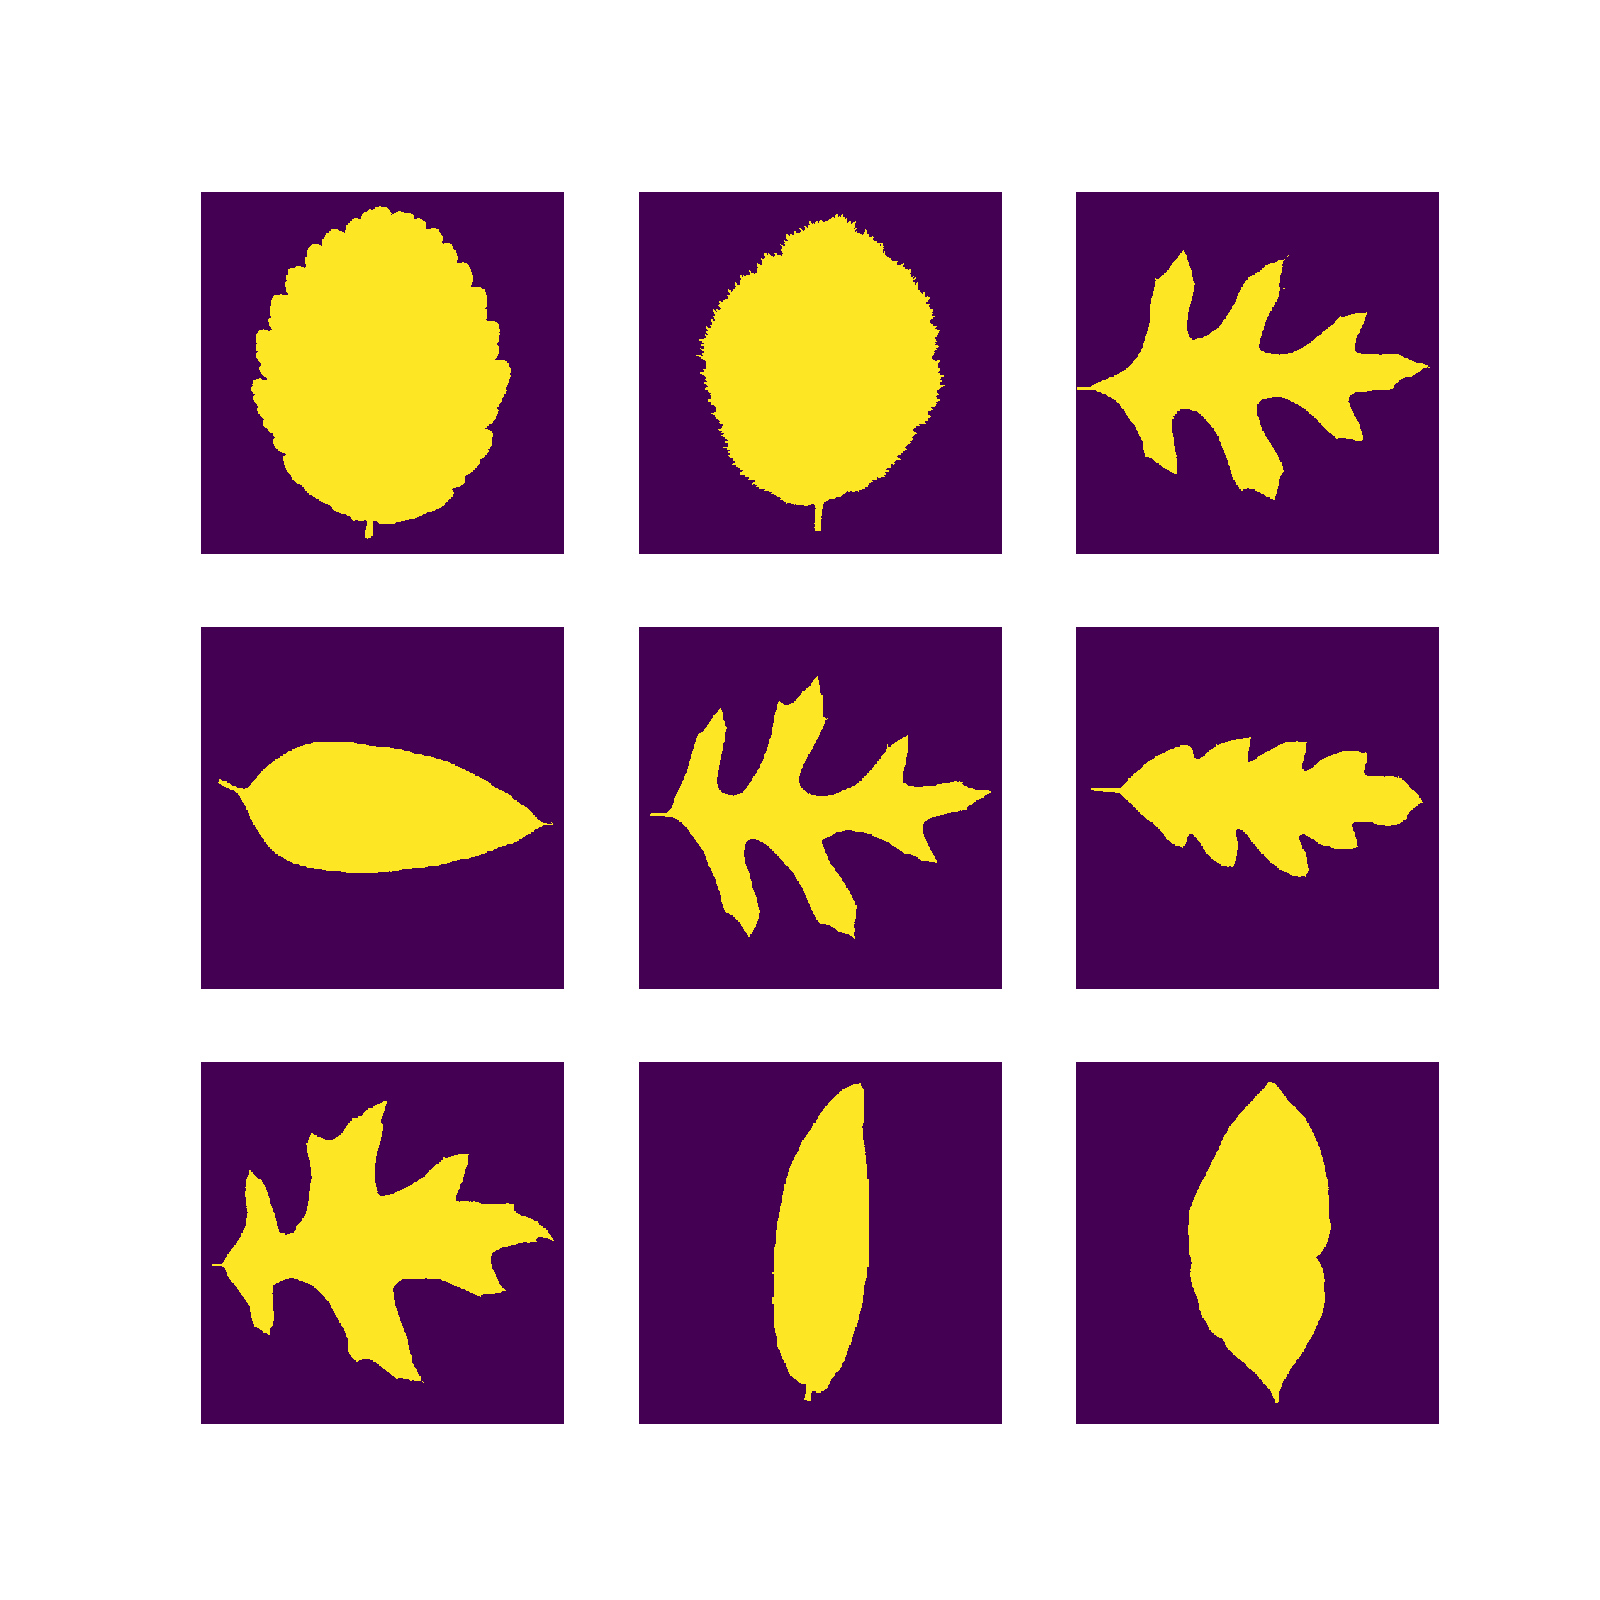

In [35]:
im, y = images_training_generator.__getitem__(2)
print(im.shape)
plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.axis('off')
    plt.imshow(im[i,:,:,0])

here we define the images model

In [36]:
def images_model():
    image = Input(shape=(image_max_size, image_max_size, 1), name='image')
    # Pass it through the first convolutional layer
    x = Conv2D(12, (4, 4), activation = 'relu')(image)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Conv2D(32, (4, 4),  activation = 'relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Conv2D(32, (4, 4),  activation = 'relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)

    x = (Conv2D(16, (4, 4),  activation = 'relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2)))(x)

    #x = (Conv2D(16, (5, 5),  activation = 'relu'))(x)
    #x = (MaxPooling2D(pool_size=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    x = Dropout(.5)(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(x)

    # Get the final output
    out = Dense(n_cats, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(inputs=image, outputs=out)

    return model

In [37]:
model = images_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 509, 509, 12)      204       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 254, 254, 12)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 251, 251, 32)      6176      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 122, 122, 32)      16416     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 32)        0         
__________

In [38]:
model.fit_generator(images_training_generator, 
                    validation_data=images_validation_generator,
                   epochs=100, callbacks = callbacks)

Epoch 1/100
66/66 [==============================] - 4s 66ms/step - loss: 3.9730 - acc: 0.1048 - val_loss: 2.6331 - val_acc: 0.2813
Epoch 2/100
66/66 [==============================] - 2s 34ms/step - loss: 1.6777 - acc: 0.5354 - val_loss: 2.0757 - val_acc: 0.5312
Epoch 3/100
66/66 [==============================] - 2s 35ms/step - loss: 0.8944 - acc: 0.7323 - val_loss: 1.9374 - val_acc: 0.5104
Epoch 4/100
66/66 [==============================] - 2s 34ms/step - loss: 0.4968 - acc: 0.8535 - val_loss: 1.9518 - val_acc: 0.5000
Epoch 5/100
66/66 [==============================] - 2s 34ms/step - loss: 0.2959 - acc: 0.9078 - val_loss: 2.4116 - val_acc: 0.5313
Epoch 6/100
66/66 [==============================] - 2s 34ms/step - loss: 0.2258 - acc: 0.9369 - val_loss: 2.1697 - val_acc: 0.5833
Epoch 7/100
66/66 [==============================] - 2s 35ms/step - loss: 0.1771 - acc: 0.9432 - val_loss: 2.2311 - val_acc: 0.5833
Epoch 8/100
66/66 [==============================] - 2s 35ms/step - loss: 0.

## Train using images but also doing data augmentation

### Testing data augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
test_augmentator= ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        vertical_flip=True)

In [17]:
ims, ys = test_augmentator.flow(X_img_tr, y_tr, batch_size=9).next()

In [18]:
plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.axis('off')
    plt.imshow(ims[i,:,:,0])
    

<IPython.core.display.Javascript object>

### Own data generator with augmentation

In [19]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator

class ImageGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, features, targets, 
                 n_classes =99, 
                 batch_size=32,  
                 shuffle=True, 
                 repeats = 1):
        
        
        self.n_classes = n_classes
        self.n_vals = len(targets)
        # since we are using data agumentation we repeat the number of times we show each image.
        # we show the same original image but it can be rotated or flipper each time, so it is not the "same" image
        self.list_IDs = np.repeat(np.arange(self.n_vals),repeats) #OJO con esto, deberian ser las imagenes validas si queremos hacer bien las cosas
        self.batch_size = batch_size
        self.features = features
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs))
        
        self.agumentator = ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.01,
        height_shift_range=0.01,
        horizontal_flip=True,
        vertical_flip=True)
          
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.features[list_IDs_temp]
        y = self.targets_mc[list_IDs_temp]

        X, y = self.agumentator.flow(X, y, batch_size=self.batch_size).next()
        
#        # Generate data
#        for i, ID in enumerate(list_IDs_temp):
#            # Store sample
#            X[i,] = np.load('data/' + ID + '.npy')
#
#            # Store class
#            y[i] = self.labels[ID]

        return X, y

In [20]:
image = Input(shape=(image_max_size, image_max_size, 1), name='image')
# Pass it through the first convolutional layer
x = Conv2D(12, (5, 5), activation = 'relu')(image)
x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

# Now through the second convolutional layer
x = (Conv2D(32, (5, 5),  activation = 'relu'))(x)
x = (MaxPooling2D(pool_size=(2, 2)))(x)

# Now through the second convolutional layer
x = (Conv2D(32, (5, 5),  activation = 'relu'))(x)
x = (MaxPooling2D(pool_size=(2, 2)))(x)

x = (Conv2D(16, (5, 5),  activation = 'relu'))(x)
x = (MaxPooling2D(pool_size=(2, 2)))(x)


# Flatten our array
x = Flatten()(x)
# Define the pre-extracted feature input
x = Dropout(.5)(x)

# Add a fully connected layer just like in a normal MLP
x = Dense(100, activation='relu')(x)

# Get the final output
out = Dense(n_cats, activation='softmax')(x)
# How we create models with the Functional API
model = Model(inputs=image, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 508, 508, 12)      312       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 254, 254, 12)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 250, 250, 32)      9632      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 121, 32)      25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 32)        0         
__________

In [21]:
batch_size = 16
params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True,}
images_validation_generator = DataGenerator(X_img_val,y_val, **params) # <-- no augmentation

params['repeats'] = 3
images_training_generator = ImageGenerator(X_img_tr,y_tr, **params)


In [24]:
model.fit_generator(images_training_generator, 
                    validation_data=images_validation_generator,
                   epochs=100, callbacks = callbacks,
                   use_multiprocessing=True,
                    max_queue_size=10,
                    workers=4)

Epoch 1/100
148/148 [==============================] - 22s 150ms/step - loss: 0.6782 - acc: 0.7618 - val_loss: 0.9660 - val_acc: 0.7604
Epoch 2/100
148/148 [==============================] - 22s 149ms/step - loss: 0.6623 - acc: 0.7741 - val_loss: 0.8169 - val_acc: 0.7708
Epoch 3/100
148/148 [==============================] - 21s 145ms/step - loss: 0.6041 - acc: 0.7867 - val_loss: 0.8042 - val_acc: 0.7708
Epoch 4/100
148/148 [==============================] - 21s 142ms/step - loss: 0.5565 - acc: 0.8024 - val_loss: 1.4293 - val_acc: 0.5625
Epoch 5/100
148/148 [==============================] - 22s 148ms/step - loss: 0.5409 - acc: 0.8117 - val_loss: 1.6936 - val_acc: 0.5729
Epoch 6/100
148/148 [==============================] - 21s 143ms/step - loss: 0.5653 - acc: 0.8036 - val_loss: 1.2173 - val_acc: 0.6875
Epoch 7/100
148/148 [==============================] - 22s 152ms/step - loss: 0.5534 - acc: 0.8091 - val_loss: 0.7461 - val_acc: 0.8229
Epoch 8/100
148/148 [===========================

plot history

# Features and Image generator


First we are going to build a generator that returns both, images and features.

In [25]:
class EnsembleGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x_tuple, targets, 
                 n_classes =99, 
                 batch_size=32,  
                 shuffle=True,
                 repeats = 1,
                 validate = False):

        # in validation mode we want the data as it comes, no agumentation or changes
        self.validate = validate
        if self.validate:
            repeats = 1
            
        features, images = x_tuple[0], x_tuple[1]
        self.n_classes = n_classes
        self.n_vals = len(targets)
        # since we are using data agumentation we repeat the number of times we show each image.
        # we show the same original image but it can be rotated or flipper each time, so it is not the "same" image
        self.list_IDs = np.repeat(np.arange(self.n_vals),repeats) #OJO con esto, deberian ser las imagenes validas si queremos hacer bien las cosas
        self.batch_size = batch_size
        self.features = features
        self.images = images        
        print('feature: {}'.format(self.features.shape))
        print('images: {}'.format(self.images.shape))
        self.shuffle = shuffle
        self.targets = targets
        self.targets_mc = keras.utils.to_categorical(targets, num_classes=self.n_classes)
        self.indexes = np.arange(len(self.list_IDs)) #this is ok
        
        self.agumentator = ImageDataGenerator(
                                    #featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    rotation_range=30,
                                    zoom_range=0.1,
                                    width_shift_range=0.01,
                                    height_shift_range=0.01,
                                    horizontal_flip=True,
                                    vertical_flip=True)
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        Xi, yi = self.__image_generation(list_IDs_temp)        
        Xf, yf = self.__feature_generation(list_IDs_temp)
        if np.all(yf==yi):
            y = yf
        else:
            print(np.argmax(self.targets_mc[list_IDs_temp],axis=1))
            print(np.argmax(yf, axis=1))
            print(np.argmax(yi, axis=1))
            raise ValueError('not equal')
                
            
        return ([Xf,Xi], y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.list_IDs
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __feature_generation(self, list_IDs_temp):
        y = self.targets_mc[list_IDs_temp]
        X = self.features[list_IDs_temp]
        return X, y
        
    def __image_generation(self, list_IDs_temp):
        # Initialization
        X = self.images[list_IDs_temp]
        yr = self.targets_mc[list_IDs_temp]
        if not self.validate:
#            X, y = self.agumentator.flow(X, y, batch_size=self.batch_size).next()
            X, y = self.agumentator.flow(X, yr, batch_size=len(list_IDs_temp), shuffle=False).next()            
            if not np.all(y==yr):
                print('not equal after agumentator')
        else:
            y = yr
        

        return X, y

In [30]:
batch_size = 16
params = {'batch_size': batch_size,
          'n_classes': 99,
          'shuffle': True,
         }
params['repeats'] = 3
ensemble_training_generator = EnsembleGenerator((X_num_tr,X_img_tr),y_tr, **params)
params['validate']=True
ensemble_validate_generator = EnsembleGenerator((X_num_val,X_img_val),y_val, **params)



feature: (792, 192)
images: (792, 512, 512, 1)
feature: (99, 192)
images: (99, 512, 512, 1)


In [31]:
print(ensemble_training_generator.features.shape)
print(ensemble_training_generator.images.shape)

(792, 192)
(792, 512, 512, 1)


In [41]:
#model = Sequential()
#model.add(Dense(64, input_shape = (192,), activation = 'relu'))
#model.add(Dropout(0.3))
#model.add(Dense(128,activation = 'relu'))
#model.add(Dense(n_cats,activation = 'softmax', name = 'out_layer'))

feature = Input(shape=(192,), name = 'feature_input')
xf = Dense(100, activation = 'relu')(feature)
xf = Dropout(0.3)(xf)
xf = Dense(100, activation='relu')(xf)

image = Input(shape=(image_max_size, image_max_size, 1), name='image_input')
# Pass it through the first convolutional layer
xi = Conv2D(12, (6, 6), activation = 'relu')(image)
xi = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(xi)
xi = (Conv2D(32, (4, 4),  activation = 'relu'))(xi)
xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
xi = (Conv2D(32, (4, 4),  activation = 'relu'))(xi)
xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
xi = (Conv2D(16, (4, 4),  activation = 'relu'))(xi)
xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
if image_max_size>256:
    xi = (Conv2D(16, (4, 4),  activation = 'relu'))(xi)
    xi = (MaxPooling2D(pool_size=(2, 2)))(xi)
xi = Flatten()(xi) # Flatten our array
xi = Dropout(.5)(xi)
xi = Dense(100, activation='relu')(xi)

xe = Concatenate(axis = -1)([xf, xi])
xe = Dropout(0.1)(xe)
xe = Dense(100, activation='relu', name='Dense_conc')(xe)
xe = Dense(50, activation='relu')(xe)

# Get the final output
out = Dense(n_cats, activation='softmax')(xe)
# How we create models with the Functional API
model = Model(inputs=[feature,image], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 507, 507, 12) 444         image_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 253, 253, 12) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 250, 250, 32) 6176        max_pooling2d_22[0][0]           
__________________________________________________________________________________________________
max_poolin

In [43]:
model.fit_generator(ensemble_training_generator, 
                    validation_data=ensemble_validate_generator,
                    epochs=100, 
                    callbacks = callbacks,
                    use_multiprocessing=True,
                    max_queue_size=10,
                    workers=4)
            
        # 'max_queue_size':5, 
         # 'workers':2, 
         # 'use_multiprocessing':True

Epoch 1/100
148/148 [==============================] - 21s 144ms/step - loss: 1.9142 - acc: 0.4033 - val_loss: 1.6638 - val_acc: 0.5000
Epoch 2/100
Epoch 1/100
148/148 [==============================] - 21s 143ms/step - loss: 1.3621 - acc: 0.5490 - val_loss: 1.2068 - val_acc: 0.6771
Epoch 3/100
148/148 [==============================] - 20s 136ms/step - loss: 1.0139 - acc: 0.6605 - val_loss: 1.0895 - val_acc: 0.7083
Epoch 4/100
148/148 [==============================] - 22s 145ms/step - loss: 0.8536 - acc: 0.7061 - val_loss: 0.8811 - val_acc: 0.7812
Epoch 5/100
148/148 [==============================] - 21s 144ms/step - loss: 0.7753 - acc: 0.7335 - val_loss: 0.5851 - val_acc: 0.7812
Epoch 6/100
148/148 [==============================] - 22s 148ms/step - loss: 0.6444 - acc: 0.7804 - val_loss: 0.7685 - val_acc: 0.7708
Epoch 7/100
148/148 [==============================] - 21s 141ms/step - loss: 0.5464 - acc: 0.8053 - val_loss: 0.6926 - val_acc: 0.8542
Epoch 8/100
148/148 [===============

In [39]:
model.history.history['val_acc']

[0.041666666666666664,
 0.3333333333333333,
 0.5520833333333334,
 0.6875,
 0.7291666666666666,
 0.8020833333333334,
 0.7916666666666666,
 0.8020833333333334,
 0.8229166666666666,
 0.8645833333333334,
 0.8541666666666666,
 0.8854166666666666,
 0.84375,
 0.8854166666666666,
 0.8645833333333334,
 0.8854166666666666,
 0.8958333333333334,
 0.8645833333333334,
 0.875,
 0.8645833333333334,
 0.8958333333333334,
 0.90625,
 0.90625,
 0.8229166666666666,
 0.9166666666666666,
 0.9166666666666666,
 0.9270833333333334,
 0.9375,
 0.8958333333333334,
 0.9270833333333334,
 0.8854166666666666,
 0.8958333333333334,
 0.90625,
 0.9166666666666666,
 0.9166666666666666,
 0.9479166666666666,
 0.9166666666666666,
 0.9166666666666666]

In [ ]:
raise Exception('hasta aca warxhs')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img

# A little hacky piece of code to get access to the indices of the images
# the data augmenter is working with.
class ImageDataGenerator2(ImageDataGenerator):
    def flow(self, X, y=None, batch_size=26, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator2(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)


class NumpyArrayIterator2(NumpyArrayIterator):
    def next(self):
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            # We changed index_array to self.index_array
            self.index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        for i, j in enumerate(self.index_array):
            x = self.X[j]
            x = self.image_data_generator.random_transform(x.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[self.index_array]
        return batch_x, batch_y

print('Creating Data Augmenter...')
imgen = ImageDataGenerator2(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
imgen_train = imgen.flow(X_img_tr, y_tr_cat, seed=np.random.randint(1, 10000))
print('Finished making data augmenter...')

In [ ]:
imgen_train[-2][1].shape

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, Concatenate

In [ ]:
next(imgen_train)

In [ ]:



def combined_model():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(8, 5, 5, input_shape=(96, 96, 1), border_mode='same')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(32, 5, 5, border_mode='same'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    concatenated = Concatenate()([x, numerical])

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(concatenated)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    model = Model(input=[image, numerical], output=out)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model = combined_model()
print('Model created!')

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


def combined_generator(imgen, X):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            x = X[imgen.index_array]
            yield [batch_img, x], batch_y

# autosave best Model
best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit_generator(combined_generator(imgen_train, X_num_tr),
                              samples_per_epoch=X_num_tr.shape[0],
                              nb_epoch=89,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              nb_val_samples=X_num_val.shape[0],
                              verbose=0,
                              callbacks=[best_model])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


def combined_generator(imgen, X):
    """
    A generator to train our keras neural network. It
    takes the image augmenter generator and the array
    of the pre-extracted features.
    It yields a minibatch and will run indefinitely
    """
    while True:
        for i in range(X.shape[0]):
            # Get the image batch and labels
            batch_img, batch_y = next(imgen)
            # This is where that change to the source code we
            # made will come in handy. We can now access the indicies
            # of the images that imgen gave us.
            x = X[imgen.index_array]
            yield [batch_img, x], batch_y

# autosave best Model
best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit_generator(combined_generator(imgen_train, X_num_tr),
                              samples_per_epoch=X_num_tr.shape[0],
                              nb_epoch=89,
                              validation_data=([X_img_val, X_num_val], y_val_cat),
                              nb_val_samples=X_num_val.shape[0],
                              verbose=0,
                              callbacks=[best_model])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

In [ ]:
id_vec['id']

In [ ]:
def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))

In [ ]:
images = []
for id_num in id_vec['id'].values:
    im = load_img(images_folder + str(id_num) +'.jpg')
    images.append(np.expand_dims(im,-1))

In [ ]:
img_to_array(im).shape

In [ ]:
resize_img(images[0])

In [ ]:
max_d0 = 0
max_d1 = 0
for im in images:
    max_d0 = max(max_d0,im.shape[0])
    max_d1 = max(max_d1,im.shape[1])   
print(max_d0, max_d1)   

In [ ]:
im.shape

In [ ]:
images_exp = []
for im in images:
#    print(im.shape)
    s0,s1,s3 = im.shape
    extra_0 =   max_d0 -s0
    extra_1 =   max_d1 - s1
    expanded = np.zeros((max_d0, max_d1, 1))
    b0, b1 = int(np.floor(extra_0/2)), int(np.floor(extra_1/2))
 #   print(b0,b1)
    expanded[b0:b0+s0,b1:b1+s1,:] = im
    images_exp.append(expanded)

images_exp = np.array(images_exp)

In [ ]:
idd = 250
print(images_exp[idd].shape)
plt.figure()
plt.imshow(images_exp[idd][:,:,0])

In [ ]:
model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=(1089, 1633,1),
               activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=99, activation='sigmoid'))

In [ ]:
model = Model(in_layer, output_layer)
model.compile(optimizer = "adam", loss = "categorical_crossentropy",
            metrics=["accuracy"])
model.summary()

In [ ]:
#in_layer = Input(shape=(1089, 1633,1))
#x = Conv2D(16,(4,4), activation = 'elu')(in_layer)  # single stride 4x4 filter for 16 maps
#x = Conv2D(32,(4,4), activation = 'elu')(x)         # single stride 4x4 filter for 32 maps
#x = Dropout(0.5)(x)
#x = Conv2D(64,(4,4), activation = 'elu')(x)         # single stride 4x4 filter for 64 maps
#x = Dropout(0.5)(x)
#x = Conv2D(128, (1,1))(x)                           # finally 128 maps for global average-pool
#x = GlobalMaxPooling2D()(x)                     # pseudo-dense 128 layer
#output_layer = Dense(99, activation = "softmax")(x) # softmax output
#
#model = Model(in_layer, output_layer)
#model.compile(optimizer = "adam", loss = "categorical_crossentropy",
#            metrics=["accuracy"])
#model.summary()

In [ ]:
model.fit(images_exp, target_mc, batch_size = 1, epochs = 50, validation_split=0.2)